### Imports

In [7]:
%pip install yfinance
%pip install matplotlib
%pip install scikit-learn
%pip install lxml

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 90.4 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import requests
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LinearRegression

## Data collection

In [19]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
}
html = requests.get(url, headers=headers)
SPY_tickers = pd.read_html(html.text)[0]['Symbol'].tolist()
SPY_tickers.append("^GSPC")

/tmp/ipykernel_11814/801941168.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  SPY_tickers = pd.read_html(html.text)[0]['Symbol'].tolist()


In [20]:
data = yf.download(SPY_tickers, start="2000-01-01", end="2025-11-25", auto_adjust=True)

[*********************100%***********************]  504 of 504 completed

4 Failed downloads:
['HON']: Timeout('Failed to perform, curl: (28) Operation timed out after 10563 milliseconds with 235479 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['GE']: Timeout('Failed to perform, curl: (28) Operation timed out after 10447 milliseconds with 219612 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2000-01-01 -> 2025-11-25)')
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')


In [21]:
data.to_parquet("data/SPY_data.pq")

## Dataset creation

In [2]:
data = pd.read_parquet("data/SPY_data.pq")

In [3]:
selected_stocks = data['Close'].columns.unique()[(data['Close'].isna().mean()<0.1)]

In [4]:
len(selected_stocks)

369

In [5]:
data.columns.get_level_values(0).unique()

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [6]:
index_returns = np.log(data['Close'][selected_stocks]).diff()['^GSPC']
df = (np.log(data['Close'][selected_stocks[:-1]]).diff()*1e4).stack().reset_index(level=1).rename(columns={0: 'close_1d_ret'})

In [7]:
df['close_1d_ret_hedged'] = np.log(data['Close'][selected_stocks[:-1]]).diff().sub(index_returns, axis=0).stack().values*1e4

In [8]:
df = df.merge((np.log(data['Close'][selected_stocks[:-1]])-np.log(data['Open'][selected_stocks[:-1]])).stack().to_frame().rename(columns={0: 'open_close_ret'})*1e4, on=['Date', 'Ticker'], how='left')

In [9]:
df = df.merge((np.log(data['Close'][selected_stocks[:-1]])-np.log(data['Open'][selected_stocks[:-1]])).sub((np.log(data['Close']['^GSPC'])-np.log(data['Open']['^GSPC'])), axis=0).stack().to_frame().rename(columns={0: 'open_close_ret_hedged'})*1e4, on=['Date', 'Ticker'], how='left')

In [10]:
df = df.merge((np.log(data['High'][selected_stocks[:-1]])-np.log(data['Low'][selected_stocks[:-1]])).stack().to_frame().rename(columns={0: 'high_low_ret'})*1e4, on=['Date', 'Ticker'], how='left')

In [11]:
df = df.merge((np.log(data['High'][selected_stocks[:-1]])-np.log(data['Low'][selected_stocks[:-1]])).sub((np.log(data['High']['^GSPC'])-np.log(data['Low']['^GSPC'])), axis=0).stack().to_frame().rename(columns={0: 'high_low_ret_hedged'})*1e4, on=['Date', 'Ticker'], how='left')

In [12]:
df = df.merge(data['Volume'][selected_stocks[:-1]].stack().reset_index(level=1).rename(columns={0: 'volume'}), on=['Date', 'Ticker'], how='left')

In [13]:
df = df.merge(data['Volume'][selected_stocks[:-1]].div(data['Volume'][selected_stocks[:-1]].sum(1), axis=0).stack().reset_index(level=1).rename(columns={0: 'share_volume'}), on=['Date', 'Ticker'], how='left')

# Feature list
1. Avg past returns close to close
2. Avg past returns open to close
3. Avg past returns low to close
4. Avg past returns high to low

- Hedged/Not hedged
- Clipped/Not clipped

# Models list

## Baseline
1. Random
2. Past returns (define period)
3. MACD vol adjusted
4. Linear Regression (define features + beta)

## LTR
1. LambdaMART (pairwise)
2. LambdaRANK (listwise)
3. ListMLE (listwise - use LightGBM)

# Baseline models

## Random Strategy

In [14]:
np.random.seed(42)
df['random_signal'] = 0.0

def assign_random_signals(group):
    n = len(group)
    if n >= 70:
        signals = np.array([1.0] * 35 + [-1.0] * 35 + [0.0] * (n - 70))
        np.random.shuffle(signals)
        return pd.Series(signals, index=group.index)
    else:
        return pd.Series(0.0, index=group.index)

df['random_signal'] = df.groupby('Date', group_keys=False).apply(assign_random_signals)


In [15]:
random_daily_returns = df.groupby('Date').apply(lambda x: (x['random_signal']*x['close_1d_ret']).mean())

<Axes: title={'center': 'Cumulative Random Strategy Return'}, xlabel='Date'>

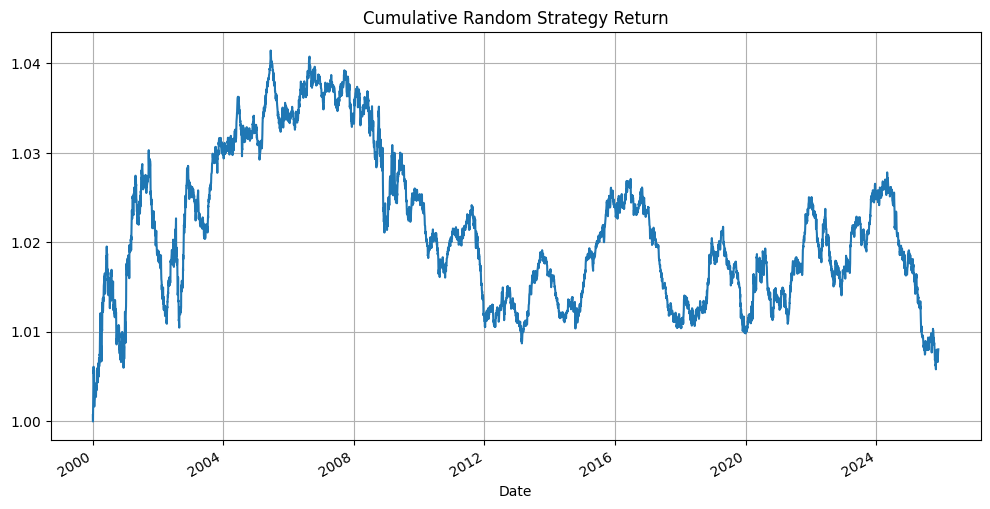

In [16]:
(random_daily_returns.cumsum()*1e-4+1).plot(figsize=(12,6), title='Cumulative Random Strategy Return', grid=True)

In [17]:
random_daily_returns.mean()/random_daily_returns.std()*np.sqrt(252)

np.float64(0.04475120341085754)

## Momentum Strategies

### Simple Momentum Strategy

In [41]:
def compute_signal(x):
    if x.notna().sum() == 0:
        return pd.Series([np.nan]*len(x), index=x.index)
    ranks = x.rank(method='first')
    binned = pd.cut(ranks, bins=10, labels=False, include_lowest=True)
    signal = binned.map(lambda y: 1 if y == 0 else (-1 if y == 9 else 0))
    return signal

In [44]:
df['momentum_hedged_signal'] = df.groupby('Date')['close_1d_ret_hedged'].transform(compute_signal)

In [45]:
df['momentum_hedged_signal'] = df.groupby('Ticker')['momentum_hedged_signal'].shift()

In [46]:
df['momentum_signal'] = df.groupby('Date')['close_1d_ret'].transform(compute_signal)

In [47]:
df['momentum_signal'] = df.groupby('Ticker')['momentum_signal'].shift()

In [48]:
momentum_daily_returns = df.groupby('Date').apply(
    lambda x: pd.Series({
        'hedged': (x['momentum_hedged_signal'] * x['close_1d_ret']).mean(),
        'unhedged': (x['momentum_signal'] * x['close_1d_ret']).mean()
    })
)*1e-4

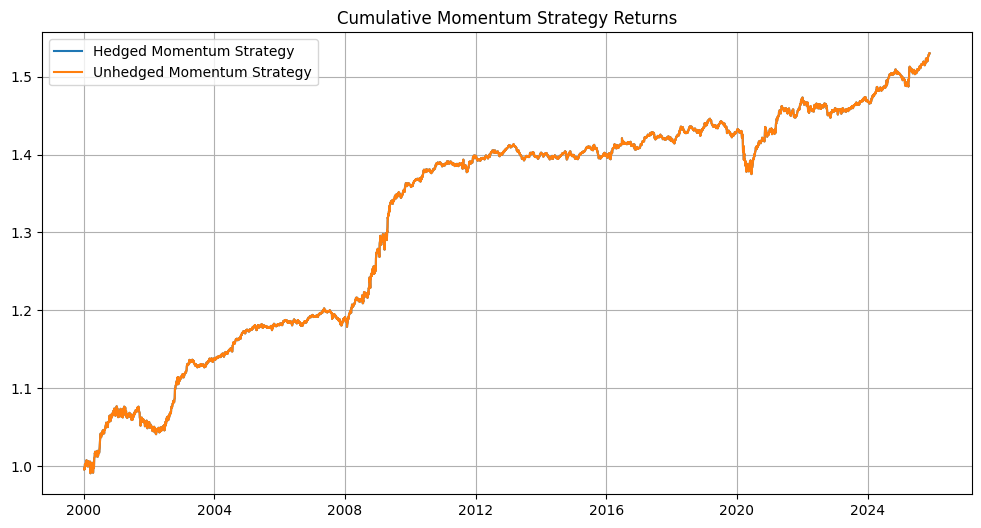

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(momentum_daily_returns['hedged'].cumsum() + 1, label='Hedged Momentum Strategy')
plt.plot(momentum_daily_returns['unhedged'].cumsum() + 1, label='Unhedged Momentum Strategy')

plt.title('Cumulative Momentum Strategy Returns')
plt.grid(True)
plt.legend()
plt.show()

In [50]:
momentum_daily_returns.mean()/momentum_daily_returns.std()*np.sqrt(252)

hedged      0.981067
unhedged    0.981067
dtype: float64

### MACD Vol adjusted Strategy

In [25]:
short_span_list = [8, 16, 32]
long_span_list = [24, 48, 96]

In [26]:
for i, (short_span, long_span) in enumerate(zip(short_span_list, long_span_list)):
    macd_adj_series = (df.groupby('Ticker')['close_1d_ret'].ewm(span=short_span, adjust=False).mean() - df.groupby('Ticker')['close_1d_ret'].ewm(span=long_span, adjust=False).mean())/df.groupby('Ticker')['close_1d_ret'].rolling(63).std()
    macd_adj_series.name = f'macd_adj_{i+1}'
    df = df.merge(macd_adj_series, on=['Date', 'Ticker'], how='right')
    df[f'macd_adj_{i+1}'] /= df[f'macd_adj_{i+1}'].rolling(252).std()

In [27]:
def phi_baz(x):
    return x / np.sqrt(1 + x**2)

In [51]:
df['macd_baz_signal'] = df[['macd_adj_1', 'macd_adj_2', 'macd_adj_3']].apply(phi_baz).sum(1).replace(0, np.nan)
df['macd_baz_signal'] = df.groupby('Date')['macd_baz_signal'].transform(compute_signal)

In [52]:
df['macd_tanh_signal'] = df[['macd_adj_1', 'macd_adj_2', 'macd_adj_3']].apply(np.tanh).sum(1).replace(0, np.nan)
df['macd_tanh_signal']  = df.groupby('Date')['macd_tanh_signal'].transform(compute_signal)

In [53]:
df['macd_baz_signal'] = df.groupby('Ticker')['macd_baz_signal'].shift()
df['macd_tanh_signal'] = df.groupby('Ticker')['macd_tanh_signal'].shift()

In [55]:
macd_daily_returns = df.groupby('Date').apply(
    lambda x: pd.Series({
        'baz': (x['macd_baz_signal'] * x['close_1d_ret']).mean(),
        'tanh': (x['macd_tanh_signal'] * x['close_1d_ret']).mean()
    })
)*1e-4

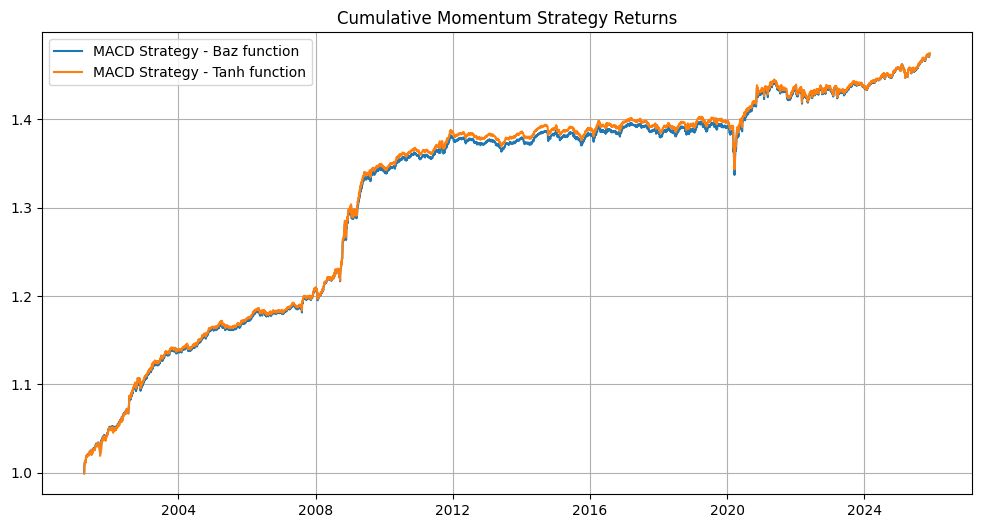

In [56]:
plt.figure(figsize=(12, 6))
plt.plot(macd_daily_returns['baz'].cumsum() + 1, label='MACD Strategy - Baz function')
plt.plot(macd_daily_returns['tanh'].cumsum() + 1, label='MACD Strategy - Tanh function')

plt.title('Cumulative Momentum Strategy Returns')
plt.grid(True)
plt.legend()
plt.show()

In [57]:
macd_daily_returns.mean()/macd_daily_returns.std()*np.sqrt(252)

baz     1.130381
tanh    1.130951
dtype: float64

# Regress-then-rank Strategies 

## Linear Regression

### Feature factory

In [62]:
def daily_metrics(group, feature, target, beta_global):
    reg = LinearRegression(fit_intercept=False)
    if len(group) < 2:
        return pd.Series({'beta': np.nan, 'bias': np.nan})
    reg.fit(group[[feature]], group[target])
    predictions = reg.predict(group[[feature]])
    bias = np.std(predictions)
    if reg.coef_[0]*beta_global < 0:
        bias *= -1
    return pd.Series({'bias': bias})

In [63]:
def single_feature_metrics(df, feature, target, fit_intercept=False):
    global_reg = LinearRegression(fit_intercept=fit_intercept)
    first_perc, last_perc = np.percentile(df[feature].dropna(), [1, 99])
    df_filtered = df[(df[feature]>=first_perc) & (df[feature]<=last_perc)]
    global_reg.fit(df_filtered[[feature]], df_filtered[target])
    predictions = global_reg.predict(df_filtered[[feature]])
    bias = np.std(predictions)
    stab = (predictions * df_filtered[target] > 0).mean() * 100
    beta_global = global_reg.coef_[0]
    bias_ts = df_filtered.groupby('Date').apply(lambda x: daily_metrics(x, feature, target, beta_global))
    mean_bias_ts = bias_ts['bias'].mean()
    sharpe_ts = bias_ts['bias'].mean() / bias_ts['bias'].std() * np.sqrt(252)
    return bias, mean_bias_ts, stab, beta_global, sharpe_ts, bias_ts

In [64]:
df['close_1d_ret_hedged_lag1'] = df.groupby('Ticker')['close_1d_ret_hedged'].shift(1)
for h in [3, 5, 10, 20, 50, 100]:
    df[f'avg_ret_hedged_{h}d'] = df.groupby('Ticker')['close_1d_ret_hedged'].transform(lambda x: x.rolling(h).mean().shift())

In [ ]:
dict_results = {'avg_ret_hedged': {}}
for h in tqdm([3, 5, 10, 20, 50, 100]): 
    dict_results['avg_ret_hedged'][h] = single_feature_metrics(df, f'avg_ret_hedged_{h}d', 'close_1d_ret_hedged')

100%|██████████| 6/6 [02:14<00:00, 22.39s/it]


In [65]:
for h in [3, 5, 10, 20, 50, 100]:
    for clip in [100, 200, 300, 400]:
        df[f'avg_ret_hedged_{h}d_clip{clip}'] = df[f'avg_ret_hedged_{h}d'].clip(-clip, clip)

In [ ]:
dict_results['avg_ret_hedged_clip'] = {}
for h in tqdm([3, 5, 10, 20, 50, 100]):
    for clip in [100, 200, 300, 400]:
        dict_results['avg_ret_hedged_clip'][(h, clip)] = single_feature_metrics(df, f'avg_ret_hedged_{h}d_clip{clip}', 'close_1d_ret_hedged')

100%|██████████| 6/6 [10:26<00:00, 104.46s/it]


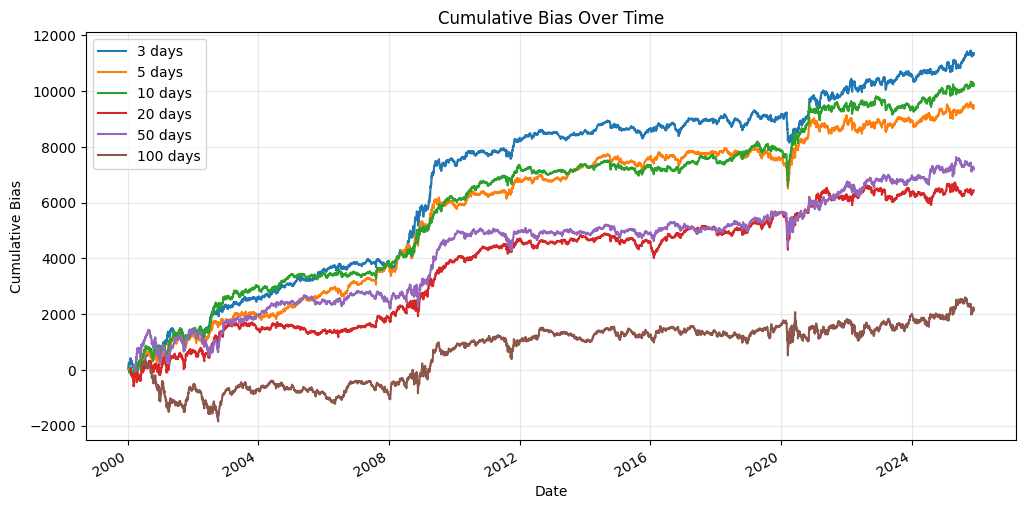

In [ ]:
plt.figure(figsize=(12, 6))
for h in dict_results['avg_ret_hedged'].keys():
    dict_results['avg_ret_hedged'][h][-1]['bias'].cumsum().plot(label=f'{h} days')
plt.legend()
plt.title('Cumulative Bias Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Bias')
plt.grid(True, alpha=0.3)
plt.show()

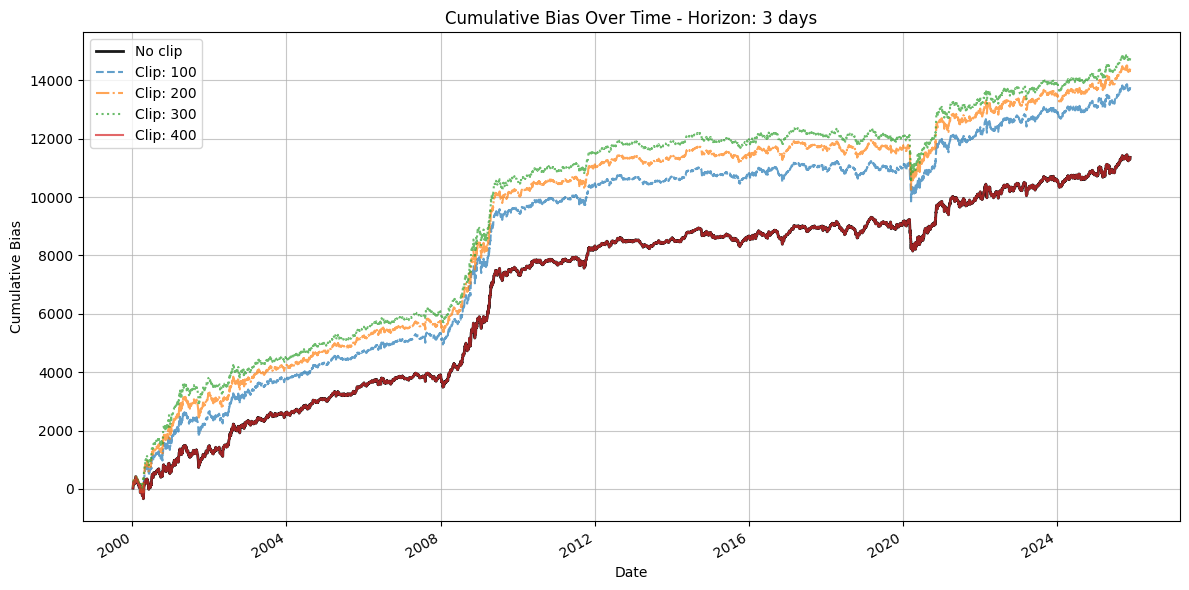

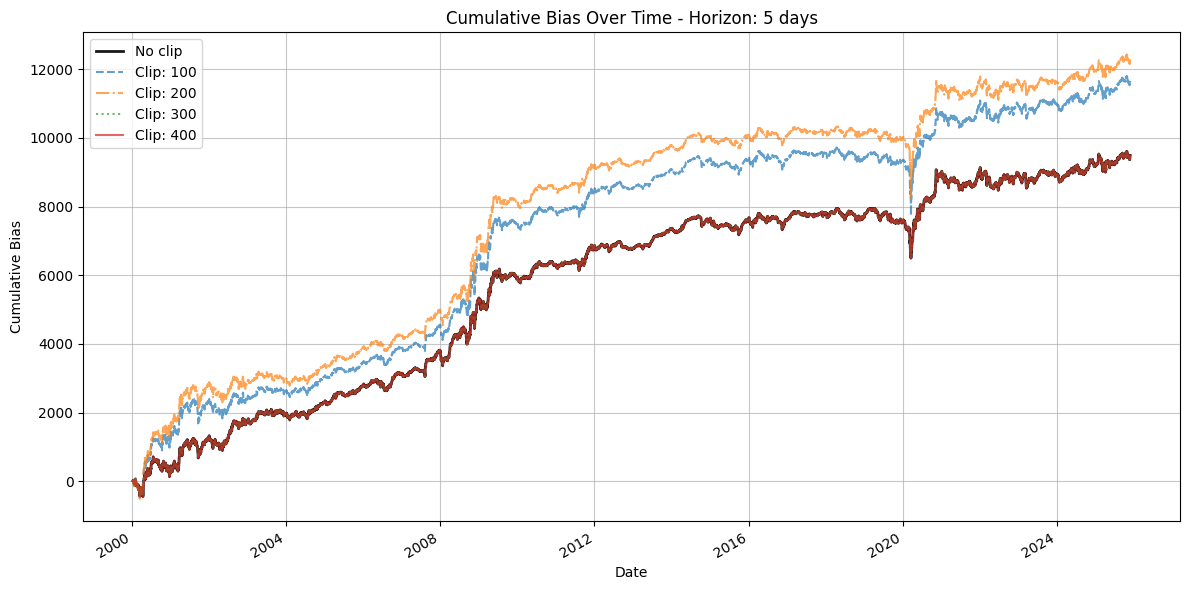

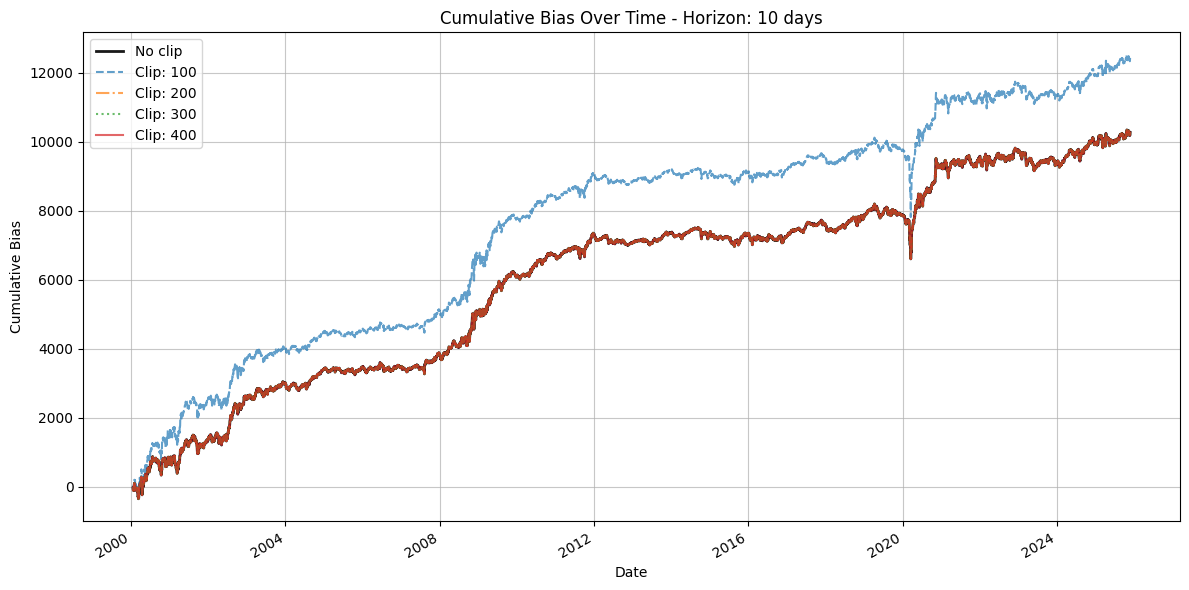

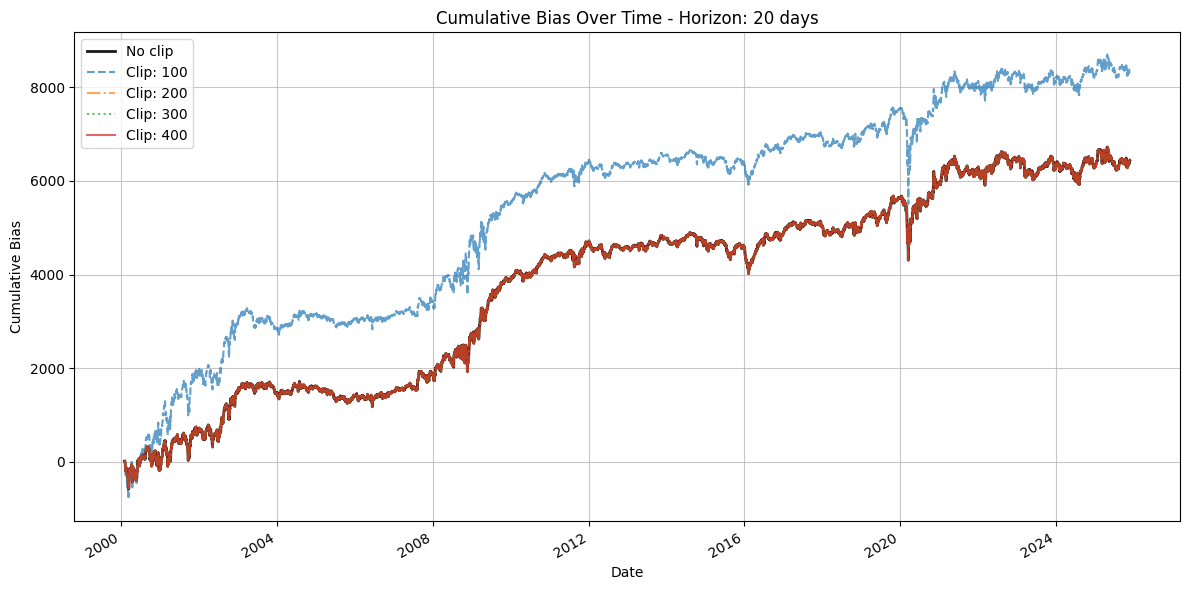

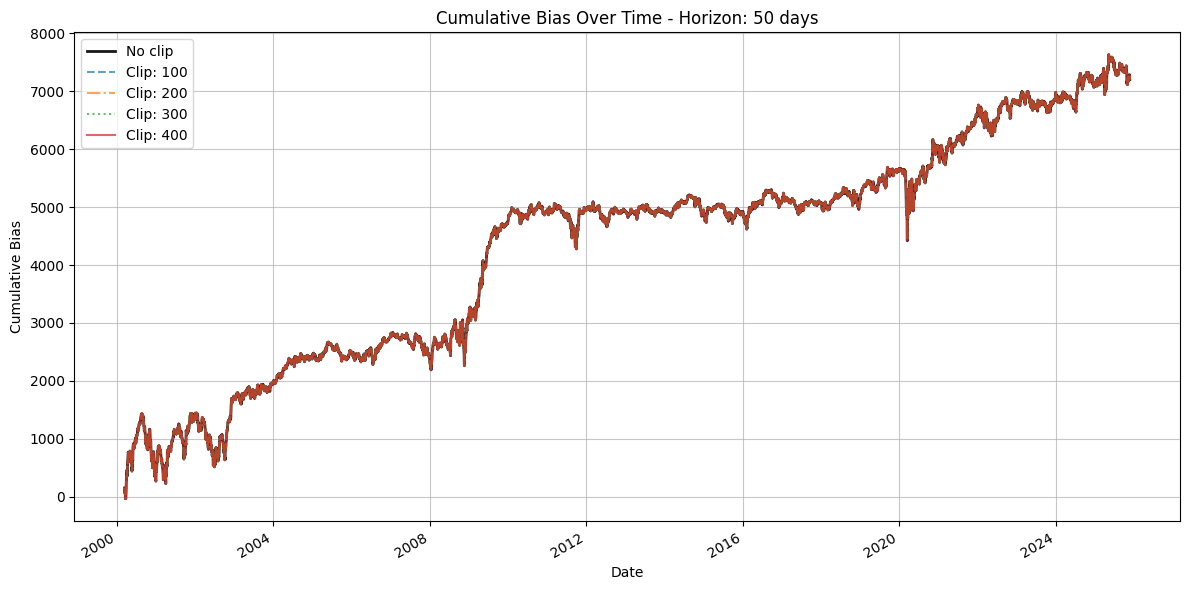

In [ ]:
for h in [3, 5, 10, 20, 50]:
    plt.figure(figsize=(12, 6))
    dict_results['avg_ret_hedged'][h][-1]['bias'].cumsum().plot(
        label=f'No clip', linewidth=2, linestyle='-', alpha=0.9, color='black'
    )
    for i, clip in enumerate([100, 200, 300, 400]):
        dict_results['avg_ret_hedged_clip'][(h, clip)][-1]['bias'].cumsum().plot(
            label=f'Clip: {clip}', linewidth=1.5, alpha=0.7, linestyle=['--', '-.', ':', '-'][i]
        )
    plt.legend()
    plt.title(f'Cumulative Bias Over Time - Horizon: {h} days')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Bias')
    plt.grid(True, alpha=0.7)
    plt.tight_layout()
    plt.show()

In [66]:
for h in [3, 5, 10, 20, 50]:
    df[f'open_close_ret_hedged_rolling_{h}'] = df.groupby('Ticker')['open_close_ret_hedged'].transform(lambda x: x.rolling(h).mean().shift())

In [ ]:
for h in tqdm([3, 5, 10, 20, 50]):
    dict_results[f'open_close_ret_hedged_rolling_{h}'] = single_feature_metrics(df, f'open_close_ret_hedged_rolling_{h}', 'close_1d_ret_hedged')

100%|██████████| 5/5 [02:12<00:00, 26.45s/it]


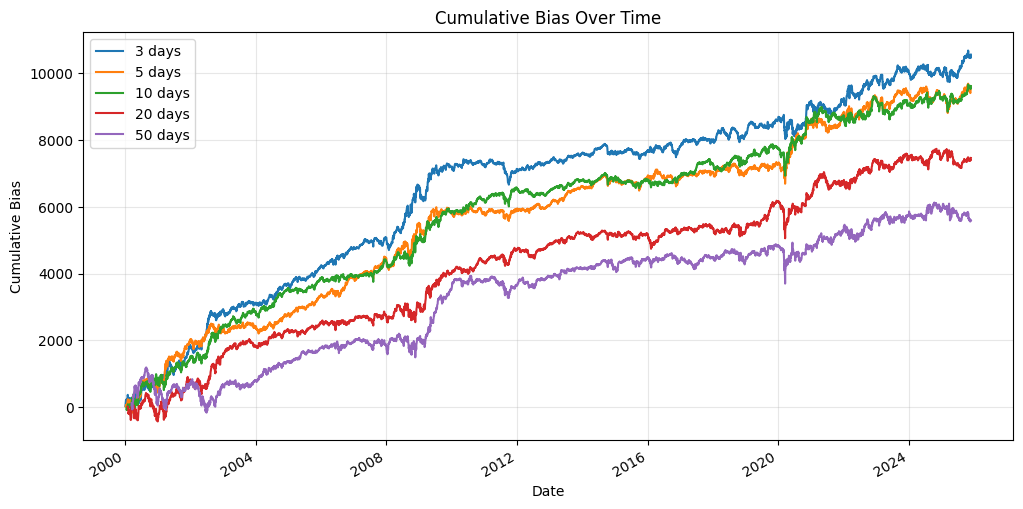

In [ ]:
plt.figure(figsize=(12, 6))
for h in [3, 5, 10, 20, 50]:
    dict_results[f'open_close_ret_hedged_rolling_{h}'][-1]['bias'].cumsum().plot(label=f'{h} days')
plt.legend()
plt.title('Cumulative Bias Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Bias')
plt.grid(True, alpha=0.3)
plt.show()

In [67]:
df[['open_close_ret_hedged_rolling_5', 'avg_ret_hedged_3d']].corr()

,open_close_ret_hedged_rolling_5,avg_ret_hedged_3d
open_close_ret_hedged_rolling_5,1.000000,0.616402
avg_ret_hedged_3d,0.616402,1.000000


In [68]:
data.columns.get_level_values(0).unique()

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')